# Decision Tree from scratch

In this exercise we'll build a portion of a decision tree classifier from scratch and compare our results to the `sklearn` implementation.

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

Our toy dataset consists of two predictors and a binary class label.

In [5]:
# Read the dataframe in
tree_df = pd.read_csv('two_classes.csv')
# Inspect the top 5 rows
tree_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
2,235,331,1
3,230,298,1
4,280,277,0


Visualizing the data we can imagine what the ideal decision boundaries might look like.

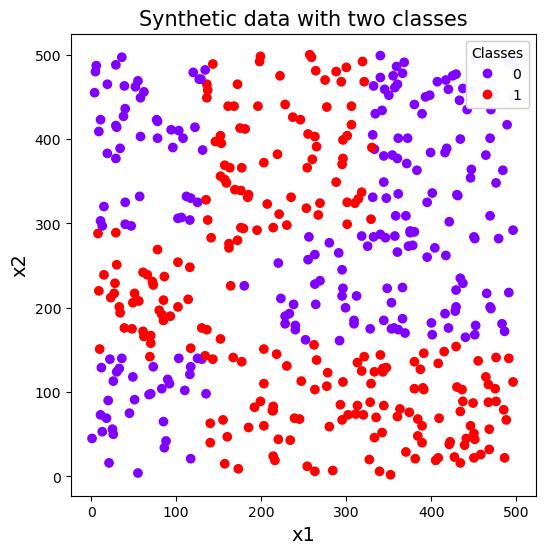

In [6]:
# Plot the data to visualize class patterns

# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6,6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('Synthetic data with two classes', fontsize='15')

# Display the plot
plt.show()

## Step 1. Establish the Root Node.
First, we need to decide what predictor to use for the 1st split and what threshold value we are splitting on. The choosen predictor & threshold will define the **Root Node** of our tree.

For candidate splits we try every unique value of each of the predictors.

To evaluate the candidate splits we'll use the Gini Impurity Index.

Remember that the Gini impurity index is defined as $1-(\sum_{i=1}^J p_i^2)$ for all $J$ classes, where $p_i$ is the probability of choosing an item from class $i$.

Because we will compare our results to `sklearn` at the end, let's use the same conventions as their `DecisionTreeClassifier`.

* Splitting conditions are stated in terms of "<= threshold"
* Points for which the splitting condition is **true** are placed in the **left** 'child' or 'leaf'. Those for which the condition is false are placed in the right child.

This differs from the convention used in the lecture slides.

In [7]:
# Function that calculates the total Gini impurity index for each value provided
def get_total_gini(predictor_values, pred_name, df):
    '''
    Parameters: 
        - preductor_values (array): an array of _unique_ predictor values,
        - pred_name (str): a name of the predictor (String),
        - df (dataframe): a corresponding dataframe object.
    Returns: an array of total Gini index for each provided predictor value.
    '''
    total_gini = []
    
    # try each value as a potential split location
    for val in predictor_values:
    
        # Left Leaf
        # counts of each class (1 or 0) to the left of candidate split
        left_1 = len(df[(df[pred_name] <= val) & (df['y'] == 1)]) # (int)
        left_0 = len(df[(df[pred_name] <= val) & (df['y'] == 0)])
        
        # total number of points on the left
        # (max with small number to avoid devision by zero later)
        N_left = max(1e-5, left_1 + left_0)

        # Gini impurity for the left leaf (Here we apply the formula)
        gini_left = 1 - ((left_1 / N_left) ** 2 + (left_0 / N_left) ** 2)
    
        # Right Leaf
        # counts of each class (1 or 0) to the right of candidate split
        right_1 = len(df[(df[pred_name] > val) & (df['y'] == 1)])
        right_0 = len(df[(df[pred_name] > val) & (df['y'] == 0)])

        # total number of points on the right
        # (max with small number to avoid division by zero later)
        N_right = max(1e-5, right_1 + right_0)
        # Gini impurity for the right leaf
        gini_right = 1 - ((right_1 / N_right) ** 2 + (right_0 / N_right) ** 2)

        # total number of points in both leaves
        N_total = N_left + N_right
        # total weighted gini impurity index
        total_gini.append((N_left / N_total) * gini_left + (N_right / N_total) * gini_right)
    
    return total_gini

The `get_total_gini` function takes *unique* predictor values as its first argument. Define these below (and consider why we want to use unique values here).

In [8]:
### edTest(test_x1_unique_values) ###

# Get unique values of x1
x1_unique = np.unique(tree_df['x1'])

In [9]:
### edTest(test_x2_unique_values) ###

# Get unique values of x2
x2_unique = np.unique(tree_df['x2'])

Now use `get_total_gini` to find the gini scores for each predictor.

In [10]:
### edTest(test_x1_total_gini) ###

# get total Gini index for x1
x1_total_gini = get_total_gini(x1_unique, 'x1', tree_df)

In [11]:
### edTest(test_x2_total_gini) ###

# get total Gini index for x2
x2_total_gini = get_total_gini(x2_unique, 'x2', tree_df)

Inspect the visualization of your results below.

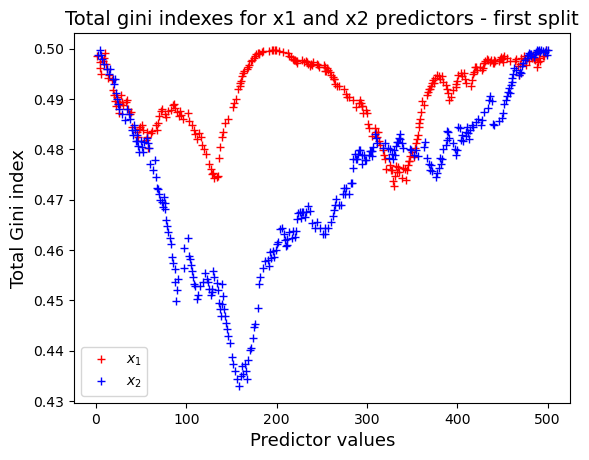

In [12]:
# plot the resulting total Gini indexes for each predictor
plt.plot(x1_unique, x1_total_gini, 'r+', label="$x_1$")
plt.plot(x2_unique, x2_total_gini, 'b+', label="$x_2$")
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total gini indexes for x1 and x2 predictors - first split", fontsize="14")
plt.legend()
plt.show()

In [13]:
def report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini):
     # Determine which predictor provides the split with the lowest Gini index.
     # We create a list of the minimum Gini indices for both x1 and x2, and find the index of the smallest Gini index. If the smallest Gini index is for x1, best_pred will be 0. If it's for x2, best_pred will be 1.
     # predictor providing the split with the lowest gini (x1=0, x2=1)
     best_pred = np.argmin([min(x1_total_gini), min(x2_total_gini)])
     
     # index of lowest gini score for best predictor
     # If best_pred is 0, we get the index from x1_total_gini; if it's 1, from x2_total_gini.
     best_gini_idx = np.argmin([x1_total_gini, x2_total_gini][best_pred])
     # best predictor value corresponding to that lowest gini score
     # Determine the value of the best predictor that corresponds to the lowest Gini index.
     # If best_pred is 0, we get the value from x1_unique; if it's 1, from x2_unique.
     best_pred_value = [x1_unique, x2_unique][best_pred][best_gini_idx]
     print("The lowest total gini score is achieved when splitting on " + f"{['x1','x2'][best_pred]} at the value {best_pred_value}.")
          
report_splits(x1_unique, x2_unique, x1_total_gini, x2_total_gini)

The lowest total gini score is achieved when splitting on x2 at the value 158.


**Getting the 1st split threshold**

The output above describes the best split among all the candidates. Each candidate split corresponded to a unique predictor value. **But this predictor value will not be our threshold value**. Instead, we use the midpoint *between* this value and the next highest unique value for that predictor in the training data (in this exercise, all data is training data).

In [14]:
### edTest(test_first_threshold) ###

# Find the threshold to split on
def get_threshold(unique_values, gini_scores):
    # index of lowest gini score
    idx = np.argmin(gini_scores)

    # I do this.
    # Check if idx is the last element
    if idx + 1 < len(unique_values):
        next_value = unique_values[idx + 1]
    else:
        next_value = unique_values[idx]  # If last element, return the element itself (no midpoint)
    
    # threshold is the midpoint between
    # the predictor value resulting in lowest gini split
    # and the next highest unique predictor value
    # (you can assume values are sorted now and during gini calculation)
    threshold = (unique_values[idx] + next_value) / 2
    return threshold

x2_threshold = get_threshold(x2_unique, x2_total_gini)
print(f"Our threshold will be {x2_threshold}")

Our threshold will be 159.5


## Step 2. Let's make our first split. 

We'll use some helper functions to assist with plotting the decision regions we get from our first split. 

`get_split_labels` determines the classification within each region based on the majority class within that region in the training data.

`predict_class` takes vectors of `x1` and `x2` values and returns a vector of predicted class labels. We predict on dummy values created with `np.meshgrid` and use the results with `plt.contourf` to plot colored decision regions.

In keeping with the convention used by `sklearn`, all points in our root node that are less than or equal to our threshold will be placed in the 'left' childe node. And the rest will go on in the 'right' child node. 

In [15]:
def get_split_labels(splits):
    '''
    Parameters:
        splits: List of ('predictor name', threshold) tuples
                Ex: [('x1', 42), ('x2', 109)]
    Returns: List of dictionaries, one for each split. 
             Dictionaries contain class labels for each side of the split
    '''
    split_labels = []
    region = tree_df
    for pred, thresh in splits:
        region_labels = {
            'left': region.loc[region[pred] <= thresh, 'y'].mode().values[0],
            'right': region.loc[region[pred] > thresh, 'y'].mode().values[0]
        }
        split_labels.append(region_labels)
        region = region[region[pred] <= thresh]
    return split_labels

# Example of how get_split_labels works
splits = [('x2', x2_threshold)]
split_labels = get_split_labels(splits)
print('class labels for the children of the root node:', split_labels)

class labels for the children of the root node: [{'left': 1, 'right': 0}]


In [16]:
def predict_class(x1, x2, splits):
    # get split labels to use when predicting
    split_labels = get_split_labels(splits)
    y_hats = []
    # iterate over each data point
    for x1_i, x2_i in zip(x1.ravel(), x2.ravel()):
        # dict lets us specify a predictor based on split rule
        obs = {'x1': x1_i, 'x2': x2_i}
        # apply each split rule
        for n_split, (pred, thresh) in enumerate(splits):
            # left
            if obs[pred] <= thresh:
                if n_split == len(splits)-1:
                    y_hats.append(split_labels[n_split]['left'])
            # right
            else:
                y_hats.append(split_labels[n_split]['right'])
                break
    return np.array(y_hats)

Now we are ready to plot our split.

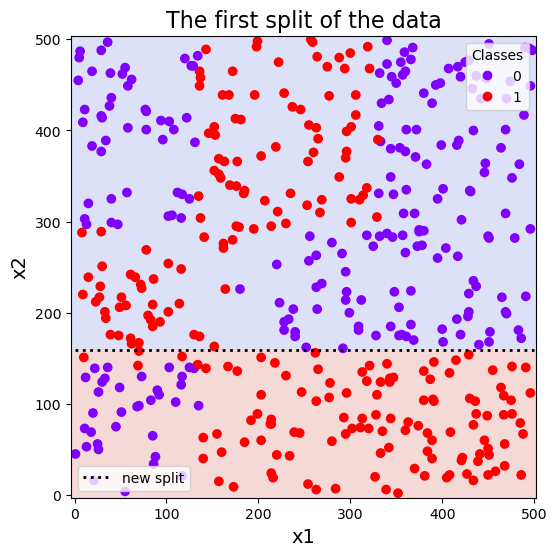

In [17]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
# Other colormaps could be found here:
# https://stackoverflow.com/questions/34314356/how-to-view-all-colormaps-available-in-matplotlib
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split line
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='14')
ax.set_ylabel('x2', fontsize='14')
ax.set_title('The first split of the data', fontsize='16')

# Plot decision regions
# dummy x1 & x2 grid values to predict on
eps = 5 # padding for the grid
xx1, xx2 = np.meshgrid(np.arange(tree_df['x1'].min()-eps, tree_df['x1'].max()+eps, 1),
                       np.arange(tree_df['x2'].min()-eps, tree_df['x2'].max()+eps, 1))
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, splits)
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Display the plot
plt.show()

We'll create a new DataFrame, `first_split_df` in which all `x2` values are less than or equal to `x2_threshold`.

This DataFrame contains the points that end up in the region corresponding to the "left leaf" or "left child" of the root node. We'll use it in the next section where we further split this region.


In [18]:
first_split_df  = tree_df[tree_df['x2'] <= x2_threshold]
# Peak at the result
first_split_df.head()

,x1,x2,y
0,143,139,1
1,117,130,0
14,265,138,1
18,230,131,1
20,140,63,1


## Step 3. Making the second split.

Now we'll run the same function as above using our new df.

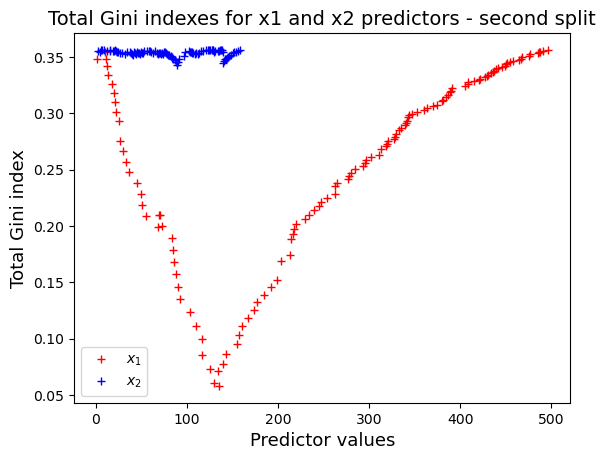

In [19]:
# provide unique values from our new dataframe
x1_unique_2split = np.unique(first_split_df['x1'].values)
x2_unique_2split = np.unique(first_split_df['x2'].values)

tot_gini_x1_2split = get_total_gini(x1_unique_2split, 'x1', first_split_df)
tot_gini_x2_2split = get_total_gini(x2_unique_2split, 'x2', first_split_df)

plt.plot(x1_unique_2split, tot_gini_x1_2split, 'r+', label='$x_1$')
plt.plot(x2_unique_2split, tot_gini_x2_2split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - second split", fontsize="14")
plt.legend()
plt.show()

In [20]:
report_splits(x1_unique_2split, x2_unique_2split,
              tot_gini_x1_2split, tot_gini_x2_2split)

The lowest total gini score is achieved when splitting on x1 at the value 135.


In [21]:
### edTest(test_second_threshold) ###

# The value to split on
# Hint: be sure to use the variables defined 
# in the 2 cells above!
x1_threshold_2split = get_threshold(x1_unique_2split, tot_gini_x1_2split)
x1_threshold_2split

137.5

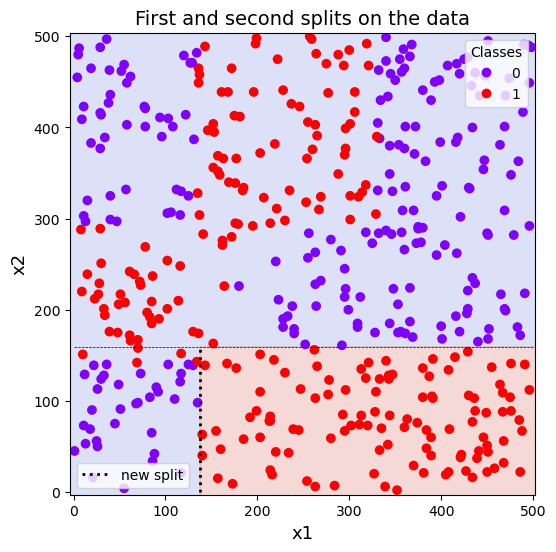

In [22]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split lines
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 0.5, ls='--')
ax.vlines(x1_threshold_2split, ymin=0, ymax=x2_threshold,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Plot decision regions
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, [('x2', x2_threshold), ('x1', x1_threshold_2split)])
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='13')
ax.set_ylabel('x2', fontsize='13')
ax.set_title('First and second splits on the data', fontsize='14')

# Display the plot
plt.show()

## Step 4. Stop splitting when the region formed is pure.

Let's split the data and check the values to the right of the threshold:


In [23]:
first_right_intern_node_df  = first_split_df[first_split_df['x1'] > x1_threshold_2split]
first_right_intern_node_df.head()

,x1,x2,y
0,143,139,1
14,265,138,1
18,230,131,1
20,140,63,1
23,340,144,1


We can see that this region is pure; all the class labels are `1`. There is no need to perform further splits on this region.


In [24]:
first_right_intern_node_df['y'].value_counts()

1    111
Name: y, dtype: int64

## Step 5. Keep doing splits on impure regions.

We stopped spliting on the right child of the second split because it was all one class, however the region represented by the left child is not pure.

In the decision tree algorithm we would keep splitting it recursively till every resulting region will become pure or we encounter another stopping condition, such as max depth.

Use the correct predictor and threshold to subset `first_split_df` to include only those points whose values are in the *left child* of our 2nd split for x1. 

Store the resulting dataframe as `second_split_left_df`.


In [25]:
second_split_left_df  = first_split_df[first_split_df['x1'] <= x1_threshold_2split]

Observe that *this* node is not pure:

In [26]:
second_split_left_df['y'].value_counts()

0    35
1     5
Name: y, dtype: int64

Let's perform a final split on this impure region.

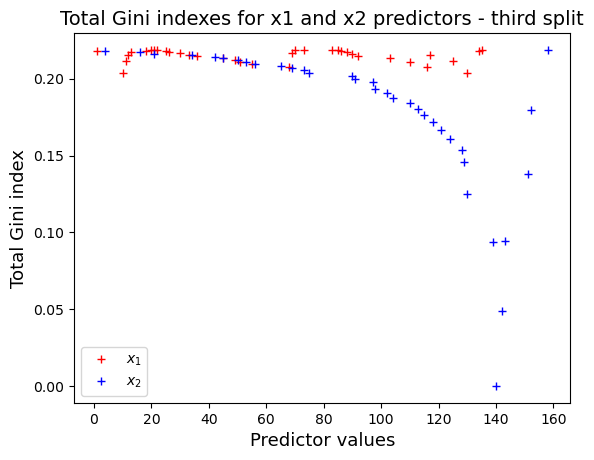

In [27]:
# Find the predictor and threshold for the split

# get unique values of x1 and x2 in this region
x1_unique_3split = np.unique(second_split_left_df['x1'].values)
x2_unique_3split = np.unique(second_split_left_df['x2'].values)

# Get total gini index for each predictor
tot_gini_x1_3split = get_total_gini(x1_unique_3split, 'x1', second_split_left_df)
tot_gini_x2_3split = get_total_gini(x2_unique_3split, 'x2', second_split_left_df)

plt.plot(x1_unique_3split, tot_gini_x1_3split, 'r+', label='$x_1$')
plt.plot(x2_unique_3split, tot_gini_x2_3split, 'b+', label='$x_2$')
plt.xlabel("Predictor values", fontsize="13")
plt.ylabel("Total Gini index", fontsize="13")
plt.title("Total Gini indexes for x1 and x2 predictors - third split", fontsize="14")
plt.legend()
plt.show()

In [28]:
report_splits(x1_unique_3split, x2_unique_3split,
              tot_gini_x1_3split, tot_gini_x2_3split)

The lowest total gini score is achieved when splitting on x2 at the value 140.


In [29]:
### edTest(test_third_threshold) ###

# The value to split on
x2_threshold_3split = get_threshold(x2_unique_3split, tot_gini_x2_3split)
x2_threshold_3split

141.0

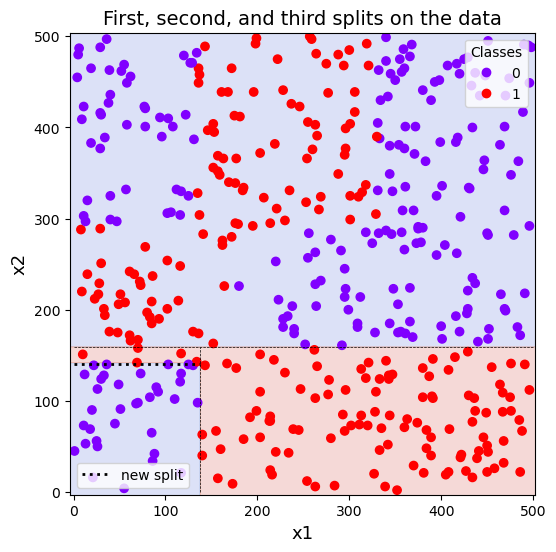

In [30]:
# Plot the split:
# Create figure of specific size and the axes objects
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter the data points
scatter = ax.scatter(tree_df['x1'], tree_df['x2'], c=tree_df['y'], cmap='rainbow')

# Create a legend object with title "Classes" and specified location on the plot
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Split lines
ax.hlines(x2_threshold, xmin=0, xmax=500,
          color ='black', lw = 0.5, ls='--')
ax.vlines(x1_threshold_2split, ymin=0, ymax=x2_threshold,
          color ='black', lw = 0.5, ls='--')
ax.hlines(x2_threshold_3split, xmin=0, xmax=x1_threshold_2split,
          color ='black', lw = 2, ls=':', label='new split')
ax.legend()

# Plot decision regions
# predict class labels on grid points
class_pred = predict_class(xx1, xx2, [('x2', x2_threshold),
                                      ('x1', x1_threshold_2split),
                                      ('x2', x2_threshold_3split)])
# contour plot for decision regions
plt.contourf(xx1, xx2, class_pred.reshape(xx1.shape), alpha=0.2, zorder=-1, cmap=plt.cm.coolwarm)

# Add labeling to the plot
ax.set_xlabel('x1', fontsize='13')
ax.set_ylabel('x2', fontsize='13')
ax.set_title('First, second, and third splits on the data', fontsize='14')

# Display the plot
plt.show()

The two leaf nodes resulting from this split are pure!

In [31]:
# Perform the split
# Get the left leaf node
left_final_leaf_df  = second_split_left_df[second_split_left_df['x2'] <= x2_threshold_3split]
# Confirm the purity of the final leaf
left_final_leaf_df['y'].value_counts()

0    35
Name: y, dtype: int64

In [32]:
# Get the right leaf node
right_final_leaf_df = second_split_left_df[second_split_left_df['x2'] > x2_threshold_3split]
# Confirm the putity of the final leaf
right_final_leaf_df['y'].value_counts()

1    5
Name: y, dtype: int64

## Comparing to SKLearn
We have just finished the left branch of the decision tree for this data. Now Let's compare our manual results with what sklearn DecisionTreeClassifier class would do. We will use a handy tree module from sklearn to visualize the produced tree.

In [33]:
# Split data into predictor matrix and target series
X = tree_df[['x1','x2']]
y = tree_df['y']

In [34]:
# Fit the tree to the data
sklearn_tree = DecisionTreeClassifier(max_depth=3)
sklearn_tree.fit(X, y)

DecisionTreeClassifier(max_depth=3)

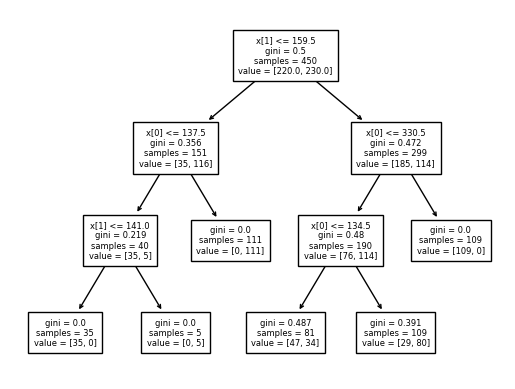

In [35]:
# Visualize the tree
tree.plot_tree(sklearn_tree, fontsize=6)
plt.show()

### As we can see above the left tree branch on the sklearn tree looks just like what we did manually above!